# **Homework 5 - USA Airport Flight Analysis**

## Importing necessary libraries

In [1]:
import numpy as np 
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

## 1. Flight Network Analysis (Q1)

In [2]:
# Loading dataset
df = pd.read_csv("Airports2.csv")
df

,Origin_airport,Destination_airport,Origin_city,Destination_city,Passengers,Seats,Flights,Distance,Fly_date,Origin_population,Destination_population,Org_airport_lat,Org_airport_long,Dest_airport_lat,Dest_airport_long
0,MHK,AMW,"Manhattan, KS","Ames, IA",21,30,1,254,2008-10-01,122049,86219,39.140999,-96.670799,NaN,NaN
1,EUG,RDM,"Eugene, OR","Bend, OR",41,396,22,103,1990-11-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
2,EUG,RDM,"Eugene, OR","Bend, OR",88,342,19,103,1990-12-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
3,EUG,RDM,"Eugene, OR","Bend, OR",11,72,4,103,1990-10-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
4,MFR,RDM,"Medford, OR","Bend, OR",0,18,1,156,1990-02-01,147300,76034,42.374199,-122.873001,44.254101,-121.150002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3606798,STL,TBN,"St. Louis, MO","Fort Leonard Wood, MO",281,969,51,119,2009-02-01,2828990,46457,38.748699,-90.370003,37.741600,-92.140701
3606799,STL,TBN,"St. Louis, MO","Fort Leonard Wood, MO",245,1026,54,119,2009-11-01,2828990,46457,38.748699,-90.370003,37.741600,-92.140701
3606800,STL,TBN,"St. Louis, MO","Fort Leonard Wood, MO",363,1273,67,119,2009-08-01,2828990,46457,38.748699,-90.370003,37.741600,-92.140701
3606801,CGI,TBN,"Cape Girardeau, MO","Fort Leonard Wood, MO",2,19,1,146,2009-08-01,93712,46457,37.225300,-89.570801,37.741600,-92.140701


In [ ]:
G = nx.DiGraph()
for _, row in df.iterrows():
    G.add_edge(row['Origin_airport'], row['Destination_airport'])

num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
density = nx.density(G)

print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")
print(f"Graph density: {density}")

Number of nodes: 727
Number of edges: 36719
Graph density: 0.0695696492245198


'\n# Degree Distribution\ndegrees = [d for _, d in G.degree()]\nplt.hist(degrees, bins=50, color=\'skyblue\', edgecolor=\'black\')\nplt.title("Degree Distribution")\nplt.xlabel("Degree")\nplt.ylabel("Frequency")\nplt.show() '

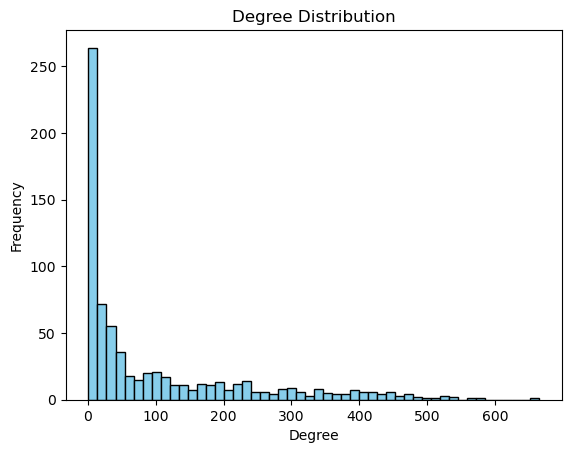

In [8]:
# Degree Distribution
degrees = [d for _, d in G.degree()]
plt.hist(degrees, bins=50, color='skyblue', edgecolor='black')
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show() 

In [ ]:
def analyse_graph_features(flight_network):
